# Basic CNN - with full dataset (16k images)

Some goals in this notebook:
- Continuation of `model_cnn.ipynb` work, but instead of training on just 2k images, we will be training on 16k images (balanced dataset on 8 classes; balancing by augmentation)
- Hyperparmater tuning using library package `optuna`, optimizing for AUC (ROC)


In [ ]:
!pip install optuna
!pip install tensorflow-addons

In [2]:
import joblib

import tensorflow as tf
import tensorflow_addons as tfa
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as sklearn_metrics

import constants
import lesion_data

## Load dataset

Here, I'm using a subbset of training data, which is a balanced dataset of all 8 classes, with 239 images each. I won't be using validation data yet (TBD).

In [3]:
random_seed = 21

train_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_validation_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

Found 16005 files belonging to 8 classes.
Found 2028 files belonging to 8 classes.


In [4]:
tf.keras.backend.clear_session()
metrics = [
    "accuracy",
    tf.metrics.Precision(name="precision"),
    tf.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
    tf.keras.metrics.AUC(curve="ROC", name="auc_roc"),
    tfa.metrics.F1Score(num_classes=8, name="f1_score"),
]

# For quality of life
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mark = "*"
        if epoch % 10 == 9:
            mark = "*|"
        print(mark, end="")

def plot_history_df(history_df: pd.DataFrame):
    x_arr = np.arange(len(history_df['loss'])) + 1

    fig = plt.figure(figsize=(18, 9))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall", "auc_pr", "auc_roc"]):
        ax = fig.add_subplot(2, 3, i+1)
        ax.plot(x_arr, history_df[metric], '-', label=f'Train {metric}')
        ax.plot(x_arr, history_df[f'val_{metric}'], '--', label=f'Validation {metric}')
        ax.legend(fontsize=10)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel(metric, size=15)

## Building and choosing a good CNN model structure using [optuna](https://optuna.org/) for hyperparameter tuning

We'll skip straight to hyperparameter tuning using Optuna. Each trial in a study will have a model that ressembles the following structure:

1. _**A**_ sets of: (choose 2 to 3 sets -- use `Sequential`)
    1. Conv2D with:
        1. _**B**_ filters (choose between 5 and 24)
        1. _**C**_ kernel size (choose 3 to 5)
        1. _**D**_ setting of padding/no padding (bool)
        1. activation: relu
    1. MaxPooling
        1. _**E**_ pool size (choose between 2 and 3)
        1. _**F**_ stride (choose between 2 and 3)
    1. Dropout - 0.1
1. Flatten
1. _**G**_ layers of Dense (choose between 0 and 3 layers; another `Sequential`)
    1. _**H**_ units (choose 5 to 20)
    1. Activation: relu
    1. Dropout - 0.1
1. One output layer of Dense
    1. output units: 8
    1. Activation: softmax


We will set up the model as something that can be manipulated by optuna, then run say 100 trials to figure out the best hyperparameters on our dataset.

In [ ]:
# Temporary code to wait on other model
# import IPython
# from os.path import exists
# import time

# path_to_other_study = "saved_models/cnn/best_model_2k_study.pkl"

# while not exists(path_to_file):
#     IPython.display.clear_output()
#     print("not ready:", time.time())
#     time.sleep(30)
    
# IPython.display.clear_output()

# Parameterize our entire model
verbose=False
IMG_SHAPE = (224, 224, 3)

best_model = None
best_auc = -1

def build_and_compile_model_optuna(trial):
    # Suggest values of the hyperparameters using a trial object.
    dropout_rate = 0.1
    # padding_global = trial.suggest_categorical("padding_global", ["same", "valid"])
    padding_global = "same"

    conv_layers = tf.keras.models.Sequential(name="conv_layers")
    for conv_layer_num in range(trial.suggest_int("total_conv_layers", 2, 3)):
        conv_layers.add(
            tf.keras.layers.Conv2D(
                filters=trial.suggest_int(f"conv_layer_{conv_layer_num}_number_of_filters", 5, 16),
                kernel_size=trial.suggest_int(f"conv_layer_{conv_layer_num}_kernel_size", 3, 5),
                activation="relu",
                padding=padding_global,
                name=f"Conv2D_{conv_layer_num}",
            )
        )
        conv_layers.add(
            tf.keras.layers.MaxPooling2D(
                pool_size=trial.suggest_int(f"conv_layer_{conv_layer_num}_pool_size", 2, 3),
                strides=trial.suggest_int(f"conv_layer_{conv_layer_num}_strides", 2, 3),
                name=f"MaxPool_{conv_layer_num}",
            )
        )
        conv_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"conv_dropout_{conv_layer_num}")
        )
        conv_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    dense_layers = tf.keras.models.Sequential(name="dense_layers")
    for dense_layer_num in range(trial.suggest_int("total_dense_layers", 0, 3)):
        dense_layers.add(
            tf.keras.layers.Dense(
                trial.suggest_int(f"dense_layer_{dense_layer_num}_dense_units", 5, 20),
                activation="relu",
                name=f"Dense_{dense_layer_num}",
            )
        )
        dense_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
        )
        dense_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    # putting it altogether
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    x = conv_layers(inputs) # Conv layers
    x = tf.keras.layers.Flatten()(x)
    x = dense_layers(x) # Dense layers

    outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=metrics,
    )

    return model

# Define an objective function to be maximized.
def objective(trial):
    tf.keras.backend.clear_session()
    
    global best_auc
    global best_model
    if verbose:
        print(f"Current {best_auc=}")
    model = build_and_compile_model_optuna(trial)
    random_seed = 21
    callbacks = [
        CustomCallback(),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=20, mode='max'),
    ]
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=int(verbose),
    )
    last_auc = history.history["val_auc_roc"][-1]

    # Additional - if it's best model, save it
    if last_auc > best_auc:
        best_auc = last_auc
        if verbose:
            print(f"New {best_auc=}")
        best_model = model
        best_model.save("saved_models/cnn/best_model_16k.h5")
        history_df = pd.DataFrame(history.history)
        history_df.to_csv("saved_models/cnn/best_model_16k_history.csv")

    joblib.dump(study, "saved_models/cnn/best_model_16k_study.pkl")
    
    return last_auc

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # fewer because training takes a much longer time

joblib.dump(study, "saved_models/cnn/best_model_16k_study.pkl")

[I 2022-12-01 16:57:11,952] A new study created in memory with name: no-name-a78d9b05-b0f0-4e3f-9624-bb5a145c2c40


Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-01 16:57:12.601 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:15818 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-01 16:57:12.627 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:15818 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
**********|**********|**********|**********|**********|**********|**********|*********

[I 2022-12-01 17:32:18,726] Trial 0 finished with value: 0.8295574188232422 and parameters: {'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 15, 'conv_layer_0_kernel_size': 5, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 2, 'conv_layer_1_number_of_filters': 12, 'conv_layer_1_kernel_size': 3, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 3, 'conv_layer_2_number_of_filters': 12, 'conv_layer_2_kernel_size': 5, 'conv_layer_2_pool_size': 3, 'conv_layer_2_strides': 2, 'total_dense_layers': 3, 'dense_layer_0_dense_units': 18, 'dense_layer_1_dense_units': 10, 'dense_layer_2_dense_units': 8}. Best is trial 0 with value: 0.8295574188232422.


*|**********|*******

In [9]:
# Killed the study prematurely because it's taking way too long
print("Total trials conducted:", len(study.trials))
joblib.dump(study, "saved_models/cnn/best_model_16k_study.pkl")

Total trials conducted: 37


['saved_models/cnn/best_model_16k_study.pkl']

## Post-train evaluation on saved model and study

Look at size of model

In [6]:
!ls saved_models/cnn -lah | grep best_model_16k.h5

-rw-r--r-- 1 root root 535K Dec  1 21:14 best_model_16k.h5


Look at "best_model" history

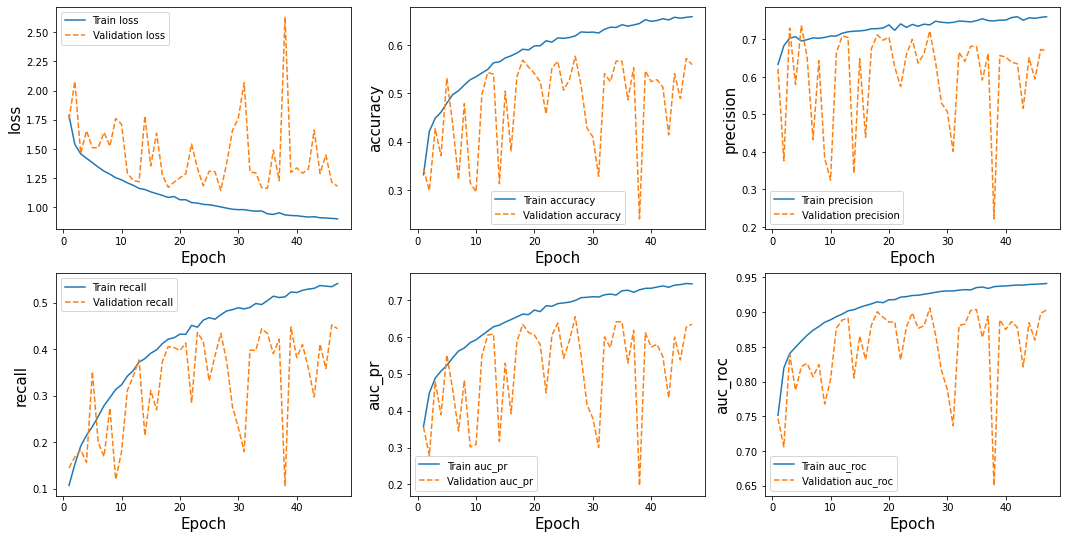

In [10]:
hist = pd.read_csv("saved_models/cnn/best_model_16k_history.csv")
plot_history_df(hist)

Thoughts: noise in validation data still exists! Overall still quite low recall.

Look at saved "best_model"

In [11]:
best_model = tf.keras.models.load_model("saved_models/cnn/best_model_16k.h5")

In [12]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_layers (Sequential)     (None, 12, 12, 11)        6791      
_________________________________________________________________
flatten (Flatten)            (None, 1584)              0         
_________________________________________________________________
dense_layers (Sequential)    (None, 20)                31780     
_________________________________________________________________
dense (Dense)                (None, 8)                 168       
Total params: 38,739
Trainable params: 38,627
Non-trainable params: 112
_________________________________________________________________


In [13]:
best_model.layers[1].summary()

Model: "conv_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_0 (Conv2D)            (None, 224, 224, 11)      308       
_________________________________________________________________
MaxPool_0 (MaxPooling2D)     (None, 74, 74, 11)        0         
_________________________________________________________________
conv_dropout_0 (Dropout)     (None, 74, 74, 11)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 11)        44        
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 74, 74, 14)        3864      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 36, 36, 14)        0         
_________________________________________________________________
conv_dropout_1 (Dropout)     (None, 36, 36, 14)        

In [14]:
best_model.layers[3].summary()

Model: "dense_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 20)                31700     
_________________________________________________________________
dense_dropout_0 (Dropout)    (None, 20)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 20)                80        
Total params: 31,780
Trainable params: 31,740
Non-trainable params: 40
_________________________________________________________________


Thoughts: it's a very small model! Very few parameters due to huge reduction in output shape from triple MaxPooling with big strides. Surprising that it works well even after that.

Let's look at what each Conv layer is learning (caveat, it's only epoch of 24).

In [15]:
model = best_model.layers[1]
model.layers[0].output

<KerasTensor: shape=(None, 224, 224, 11) dtype=float32 (created by layer 'Conv2D_0')>

In [16]:
one_batch_ds = validation_ds.take(1).as_numpy_iterator()
one_batch = next(one_batch_ds)
one_image, one_image_label = one_batch[0], one_batch[1]

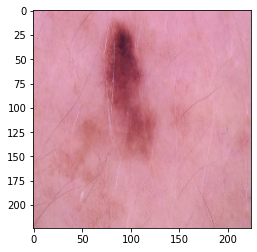

In [17]:
plt.imshow(one_image[0].astype(int))

----------------
Geeting activations of layer 1 : Conv2D_0
Images size is 224 x 224
Number of channels is 11
Printing channels:


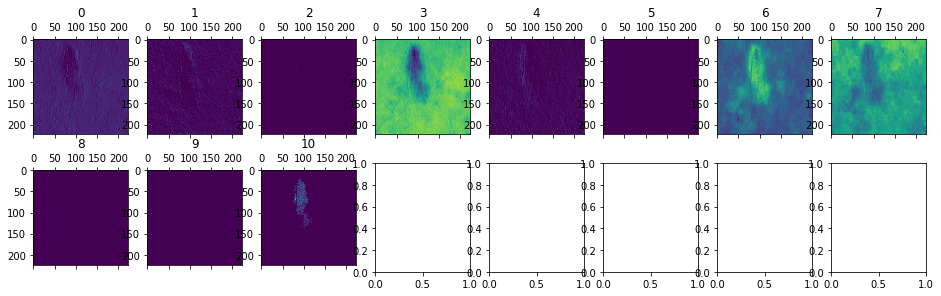

----------------
Geeting activations of layer 2 : MaxPool_0
Images size is 74 x 74
Number of channels is 11
Printing channels:


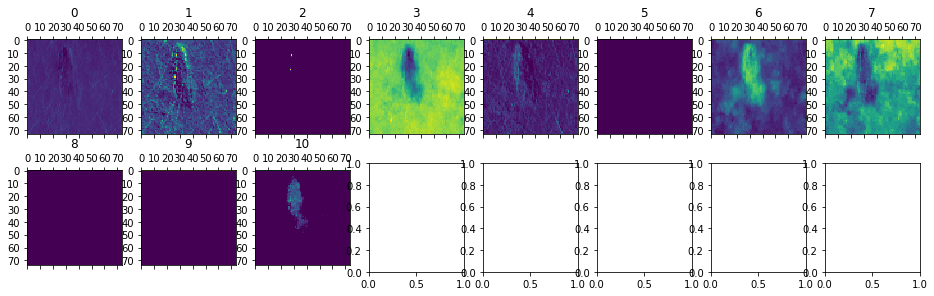

skipping conv_dropout_0
skipping batch_normalization
----------------
Geeting activations of layer 5 : Conv2D_1
Images size is 74 x 74
Number of channels is 14
Printing channels:


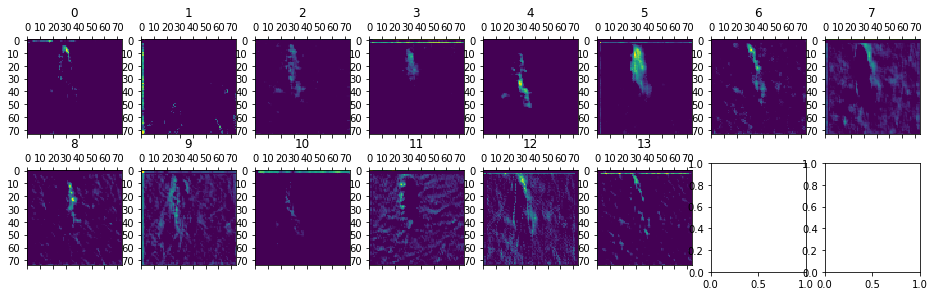

----------------
Geeting activations of layer 6 : MaxPool_1
Images size is 36 x 36
Number of channels is 14
Printing channels:


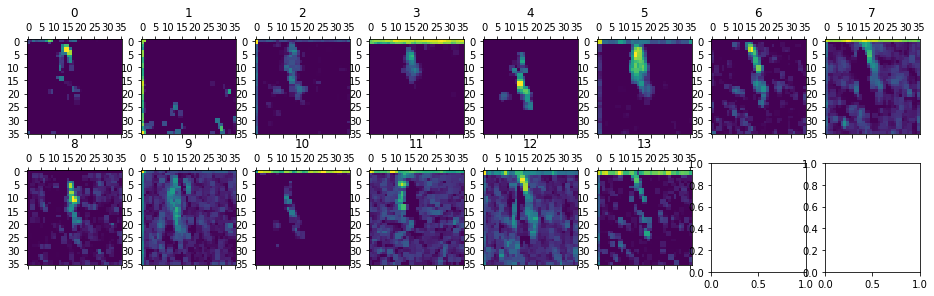

skipping conv_dropout_1
skipping batch_normalization_1
----------------
Geeting activations of layer 9 : Conv2D_2
Images size is 36 x 36
Number of channels is 11
Printing channels:


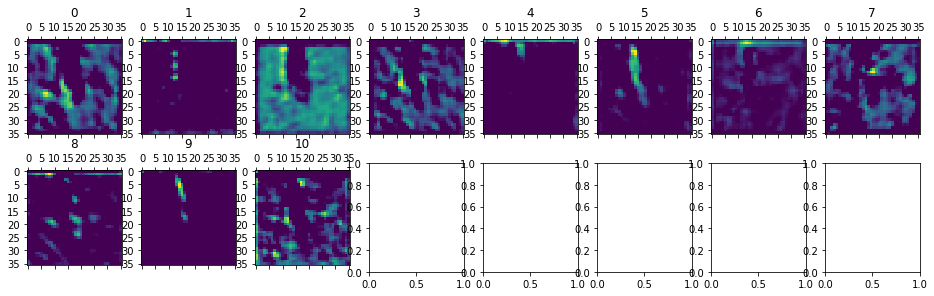

----------------
Geeting activations of layer 10 : MaxPool_2
Images size is 12 x 12
Number of channels is 11
Printing channels:


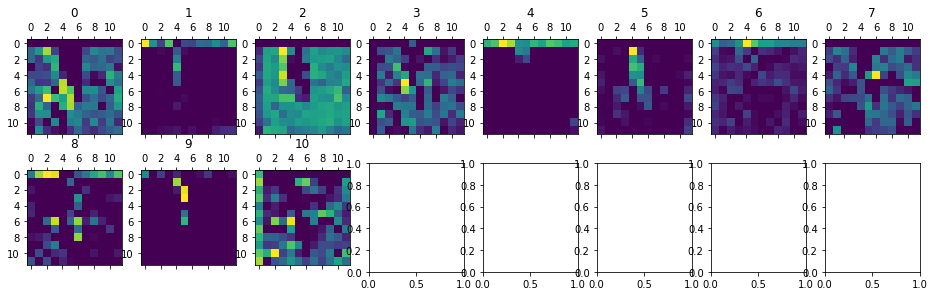

skipping conv_dropout_2
skipping batch_normalization_2


In [18]:
# outputs of layers that are conv2D and max pooling layers
model = best_model.layers[1]
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(one_image)

# vis to skip
models_to_skip = ["dropout", "batch_normalization"]
plots_per_row = 8

# grab layer names
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    skip = False
    for keyword in models_to_skip:
        if keyword in layer_names[idx]:
            print(f"skipping {model.layers[idx].name}")
            skip = True  # skip plotting

    if skip:
        continue

    print('----------------')
    print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
    activation = layer

    # shape of layer activation
    print('Images size is', activation.shape[1], 'x', activation.shape[2])
    print('Number of channels is', activation.shape[3])

    # print channels
    print('Printing channels:')

    number_of_channels = activation.shape[-1]
    # define nrows and ncols depending on number of channels
    nrows, ncols = int(np.ceil(number_of_channels / plots_per_row)), plots_per_row

    # plots
    channel=0
    f, axs = plt.subplots(nrows, ncols, figsize=(plots_per_row * 2, nrows * 2.2))

    for channel in range(number_of_channels):
        i, j = int(np.floor(channel / plots_per_row)), int(channel % plots_per_row)
        axs[i,j].matshow(activation[0, :, :, channel], cmap ='viridis')
        axs[i,j].set(title=str(channel))
        #axs[i,j].axis('off') # pay attention to the range of x and y axis
    
    plt.show()

Analyze what optuna learned.

In [10]:
loaded_study = joblib.load("saved_models/cnn/best_model_16k_study.pkl")

In [11]:
loaded_study.best_trial

FrozenTrial(number=11, values=[0.9032914638519287], datetime_start=datetime.datetime(2022, 12, 1, 20, 54, 51, 182515), datetime_complete=datetime.datetime(2022, 12, 1, 21, 14, 50, 306895), params={'total_conv_layers': 3, 'conv_layer_0_number_of_filters': 11, 'conv_layer_0_kernel_size': 3, 'conv_layer_0_pool_size': 3, 'conv_layer_0_strides': 3, 'conv_layer_1_number_of_filters': 14, 'conv_layer_1_kernel_size': 5, 'conv_layer_1_pool_size': 3, 'conv_layer_1_strides': 2, 'conv_layer_2_number_of_filters': 11, 'conv_layer_2_kernel_size': 4, 'conv_layer_2_pool_size': 2, 'conv_layer_2_strides': 3, 'total_dense_layers': 1, 'dense_layer_0_dense_units': 20}, distributions={'total_conv_layers': IntDistribution(high=3, log=False, low=2, step=1), 'conv_layer_0_number_of_filters': IntDistribution(high=16, log=False, low=5, step=1), 'conv_layer_0_kernel_size': IntDistribution(high=5, log=False, low=3, step=1), 'conv_layer_0_pool_size': IntDistribution(high=3, log=False, low=2, step=1), 'conv_layer_0_st

In [12]:
loaded_study.best_trial.params

{'total_conv_layers': 3,
 'conv_layer_0_number_of_filters': 11,
 'conv_layer_0_kernel_size': 3,
 'conv_layer_0_pool_size': 3,
 'conv_layer_0_strides': 3,
 'conv_layer_1_number_of_filters': 14,
 'conv_layer_1_kernel_size': 5,
 'conv_layer_1_pool_size': 3,
 'conv_layer_1_strides': 2,
 'conv_layer_2_number_of_filters': 11,
 'conv_layer_2_kernel_size': 4,
 'conv_layer_2_pool_size': 2,
 'conv_layer_2_strides': 3,
 'total_dense_layers': 1,
 'dense_layer_0_dense_units': 20}

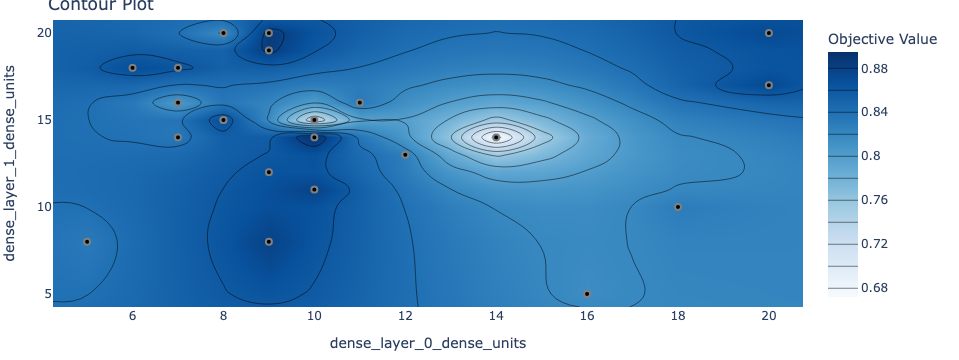

In [13]:
fig = optuna.visualization.plot_contour(
    loaded_study,
    params=[
        # 'padding_global',
        # 'total_conv_layers',
        # 'conv_layer_0_number_of_filters',
        # 'conv_layer_0_kernel_size',
        # 'conv_layer_0_pool_size',
        # 'conv_layer_0_strides',
        # 'conv_layer_1_number_of_filters',
        # 'conv_layer_1_kernel_size',
        # 'conv_layer_1_pool_size',
        # 'conv_layer_1_strides',
        # 'conv_layer_2_number_of_filters',
        # 'conv_layer_2_kernel_size',
        # 'conv_layer_2_pool_size',
        # 'conv_layer_2_strides',
        # 'total_dense_layers',
        'dense_layer_0_dense_units',
        'dense_layer_1_dense_units',
    ],
)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)

(Screenshot of above for GitHub)
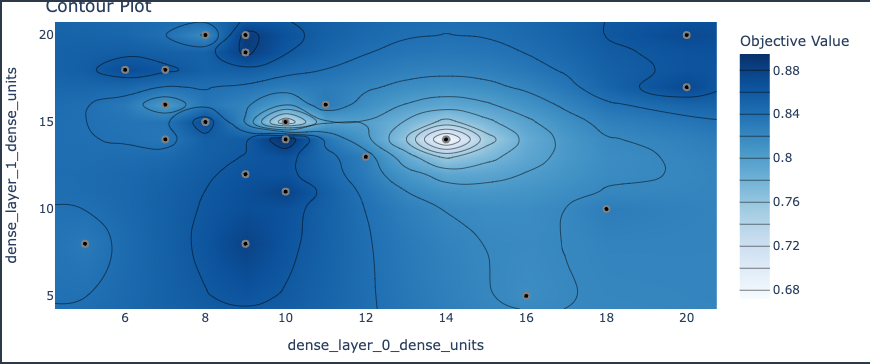

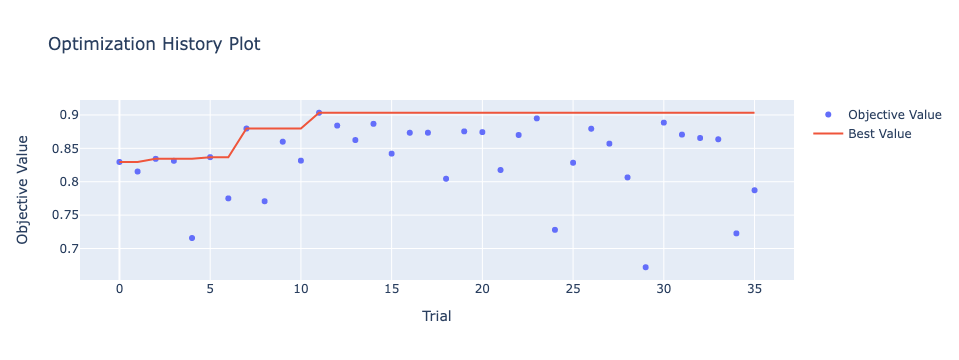

In [14]:
fig = optuna.visualization.plot_optimization_history(loaded_study)
display(fig)

(Screenshot of above for GitHub)
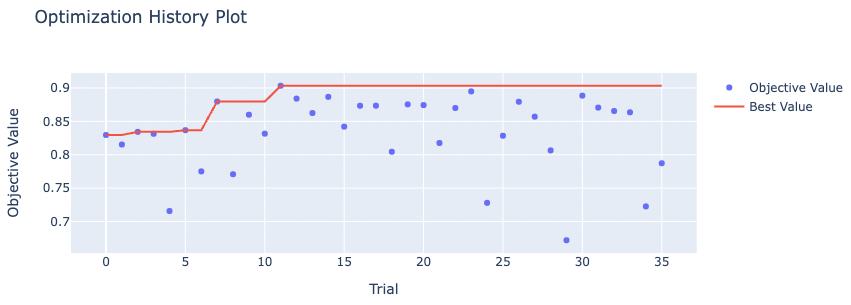

### From best metrics, build the same model again

This is from lack of foresight at the beginning of the project -- adding in-model augmentation and increasing dropouts can prevent overfitting and improve validation metrics. We don't have time to rerun the entire optuna study, but we will take the best model's hyperparameters and re-run with these best practices.

In [5]:
# Parameterize our entire model
verbose=False
IMG_SHAPE = (224, 224, 3)

dropout_rate = 0.2
padding_global = "same"

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.5),
    ],
    name="mini_augmentation",
)

conv_layers = tf.keras.models.Sequential(
    name="conv_layers",
    layers=[
        # First layer
        tf.keras.layers.Conv2D(
            filters=11,
            kernel_size=3,
            activation="relu",
            padding=padding_global,
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=3,
            strides=3,
        ),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.BatchNormalization(),
        
        # Second layer
        tf.keras.layers.Conv2D(
            filters=14,
            kernel_size=5,
            activation="relu",
            padding=padding_global,
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=3,
            strides=2,
        ),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.BatchNormalization(),
        
        # Third layer
        tf.keras.layers.Conv2D(
            filters=11,
            kernel_size=4,
            activation="relu",
            padding=padding_global,
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=3,
            strides=3,
        ),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.BatchNormalization(),
    ],
)


dense_layers = tf.keras.models.Sequential(
    name="dense_layers",
    layers=[
        tf.keras.layers.Dense(
            20,
            activation="relu",
        ),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.BatchNormalization(),
    ],
)

# putting it altogether
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)
x = conv_layers(x) # Conv layers
x = tf.keras.layers.Flatten()(x)
x = dense_layers(x) # Dense layers

outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

random_seed = 21
callbacks = [
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=20, mode='max'),
]
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=int(verbose),
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mini_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
conv_layers (Sequential)     (None, 12, 12, 11)        6791      
_________________________________________________________________
flatten (Flatten)            (None, 1584)              0         
_________________________________________________________________
dense_layers (Sequential)    (None, 20)                31780     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 168       
Total params: 38,739
Trainable params: 38,627
Non-trainable params: 112
_______________________________________________________

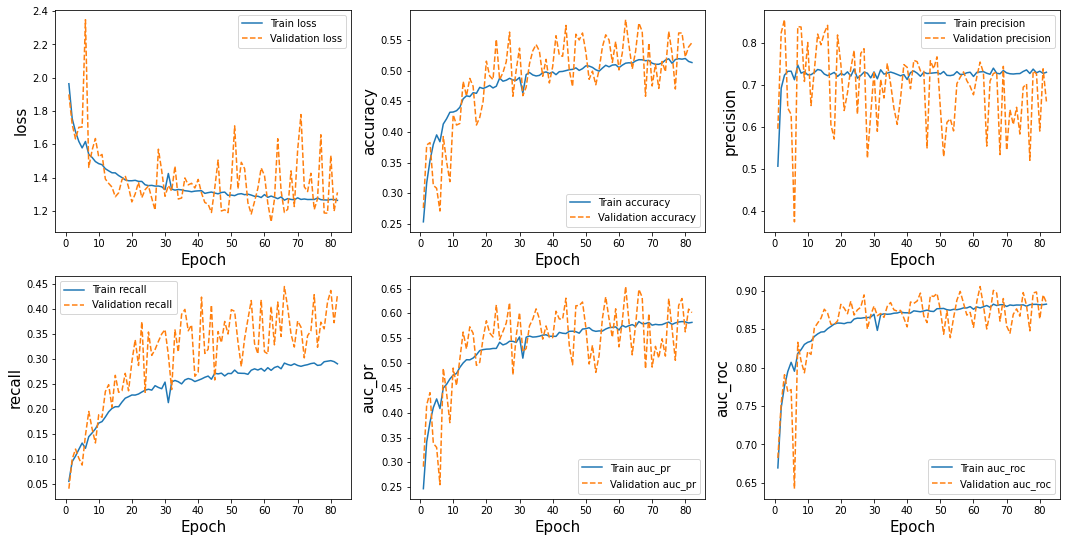

In [6]:
history_df = pd.DataFrame(history.history)
plot_history_df(history_df)

The model is way less overfitted, although validation performance is comparable to previous version.

In [7]:
history_df.to_csv("saved_models/cnn/best_model_modified_16k_history.csv")
model.save("saved_models/cnn/best_model_modified_16k.h5")

## Evaluation on test data

Finally, using the best model, we train on our best model identified using Optuna.

In [8]:
random_seed = 21
test_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_testing_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

# Load model from saved file
best_model = tf.keras.models.load_model("saved_models/cnn/best_model_modified_16k.h5")

best_model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

Found 5066 files belonging to 8 classes.


In [9]:
results = best_model.evaluate(test_ds)

for n, v in zip(best_model.metrics_names, results):
    try:
        print(f"{n}\t: {v:.3f}")
    except:
        print(f"{n}\t: {v}")

159/159 [==============================] - 9s 45ms/step - loss: 1.3125 - accuracy: 0.5513 - precision: 0.6558 - recall: 0.4322 - auc_pr: 0.6036 - auc_roc: 0.8855 - f1_score: 0.2941
loss	: 1.312
accuracy	: 0.551
precision	: 0.656
recall	: 0.432
auc_pr	: 0.604
auc_roc	: 0.885
f1_score	: [0.08965518 0.19892475 0.31818184 0.06315789 0.40000004 0.77655673
 0.05797101 0.44827586]


In [10]:
test_preds = best_model.predict(test_ds)
test_preds_sparse = np.argmax(test_preds, axis=1)

labels_iterator=test_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_dense = np.array(list(labels_iterator))
labels_sparse = np.argmax(labels_dense, axis=1)

labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
y_true = sorted_to_real_fn(labels_sparse)
y_pred = sorted_to_real_fn(test_preds_sparse)

Classification Report
              precision    recall  f1-score   support

         MEL      0.206     0.126     0.157       895
          NV      0.517     0.535     0.526      2592
         BCC      0.157     0.028     0.047       684
          AK      0.025     0.006     0.010       160
         BKL      0.092     0.293     0.140       502
          DF      0.000     0.000     0.000        44
        VASC      0.000     0.000     0.000        47
         SCC      0.000     0.000     0.000       142

    accuracy                          0.329      5066
   macro avg      0.125     0.124     0.110      5066
weighted avg      0.332     0.329     0.317      5066

Accuracy: 0.3293
ROC AUC: 0.4918


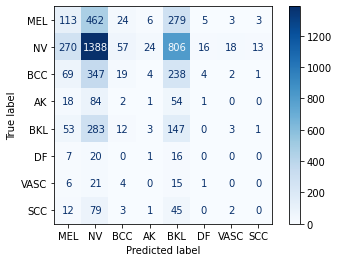

In [11]:
print ("Classification Report")
print(sklearn_metrics.classification_report(y_true, y_pred, labels=range(8), target_names=labels, digits=3))
print(f"Accuracy: {sklearn_metrics.accuracy_score(y_true, y_pred):.4f}")
#'ovr' Stands for One-vs-rest. Computes the AUC of each class against the rest
print(f"ROC AUC: {sklearn_metrics.roc_auc_score(labels_dense, test_preds, multi_class='ovr'):.4f}")

cm = sklearn_metrics.confusion_matrix(y_true, y_pred)
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()